**Chapter 15 – Processing Sequences Using RNNs and CNNs**

_This notebook contains all the sample code in chapter 15._

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/15_processing_sequences_using_rnns_and_cnns.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [ ]:
!pip uninstall keras -y
!pip install --upgrade torch
!pip install -q keras-nightly
import os

import torch

os.environ["KERAS_BACKEND"] = "torch"

import keras
#import tensorflow as tf
import numpy as np


Found existing installation: keras 3.4.1
Uninstalling keras-3.4.1:
  Successfully uninstalled keras-3.4.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 20.9 MB/s eta 0:00:00


In [ ]:
print(keras.__version__)

3.7.0.dev2024102703


In [ ]:
os.environ["KERAS_BACKEND"]

'torch'

In [ ]:
use_cuda = torch.cuda.is_available()
if use_cuda:
    print('__CUDNN VERSION:', torch.backends.cudnn.version())
    print('__Number CUDA Devices:', torch.cuda.device_count())
    print('__CUDA Device Name:',torch.cuda.get_device_name(0))
    print('__CUDA Device Total Memory [GB]:',torch.cuda.get_device_properties(0).total_memory/1e9)
else:
    print('GPU is NOT available')

__CUDNN VERSION: 90100
__Number CUDA Devices: 1
__CUDA Device Name: Tesla T4
__CUDA Device Total Memory [GB]: 15.835660288


In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# Common imports
import numpy as np
import os
from pathlib import Path

# to make this notebook's output stable across runs
np.random.seed(42)
torch.manual_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
def plot_learning_curves(loss, val_loss):
    plt.plot(torch.arange(len(loss)).cpu().numpy() + 0.5, loss.cpu().numpy(), "b.-", label="Training loss")
    plt.plot(torch.arange(len(val_loss)).cpu().numpy() + 1, val_loss.cpu().numpy(), "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

In [ ]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(torch.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual")
    plt.plot(torch.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)


#Pytorch functions

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
from tqdm import tqdm

# Function to train model with batching
def train_model(model, X_train, y_train, X_valid, y_valid, optimizer, criterion, device, batch_size=32, epochs=20):
    # Create DataLoader for training and validation datasets
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    valid_dataset = TensorDataset(X_valid, y_valid)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

    for epoch in tqdm(range(epochs)):
        model.train()  # Set model to training mode
        running_loss = 0.0

        # Training loop over batches
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()  # Zero the gradients

            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)

            # Forward pass
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * batch_X.size(0)  # Accumulate batch loss

        # Compute average training loss
        train_loss = running_loss / len(train_loader.dataset)

        # Validation phase
        model.eval()  # Set model to evaluation mode
        valid_loss = 0.0
        with torch.no_grad():
            for batch_X, batch_y in valid_loader:

                batch_X = batch_X.to(device)
                batch_y = batch_y.to(device)

                val_outputs = model(batch_X)
                val_loss = criterion(val_outputs, batch_y)
                valid_loss += val_loss.item() * batch_X.size(0)

        valid_loss = valid_loss / len(valid_loader.dataset)  # Compute average validation loss

        print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}')



In [ ]:

def evaluate_model(model, X_valid, y_valid, device, batch_size=32):
    # Set model to evaluation mode
    model.eval()

    # Create DataLoader for validation set
    valid_dataset = TensorDataset(X_valid, y_valid)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

    valid_loss = 0.0
    criterion = nn.MSELoss()  # Assuming MSE loss is used, as in the Keras example

    # Disable gradient computation for evaluation
    with torch.no_grad():
        for batch_X, batch_y in valid_loader:

            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)

            # Forward pass
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            valid_loss += loss.item() * batch_X.size(0)  # Accumulate batch loss

    # Compute average validation loss
    avg_valid_loss = valid_loss / len(valid_loader.dataset)

    print(f'Validation Loss: {avg_valid_loss:.4f}')
    return avg_valid_loss

# Basic RNNs

### Generate the Dataset

In [ ]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = torch.rand(4, batch_size, 1)
    time = torch.linspace(0, 1, n_steps)
    series = 0.5 * torch.sin((time - offsets1) * (freq1 * 10 + 10))  # wave 1
    series += 0.2 * torch.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (torch.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., None].type(torch.float32) # same as series[..., np.newaxis].astype(np.float32) in numpy

In [ ]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [ ]:
X_train.shape, y_train.shape

(torch.Size([7000, 50, 1]), torch.Size([7000, 1]))

Saving figure time_series_plot


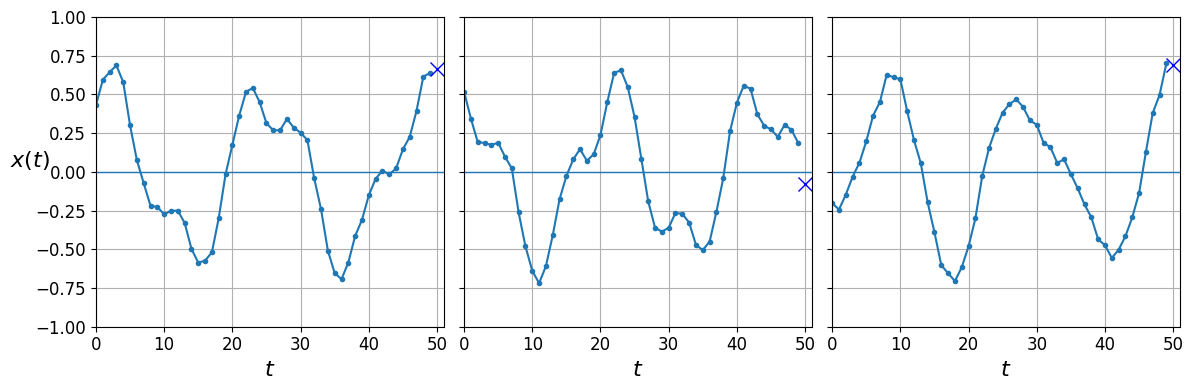

In [ ]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))
save_fig("time_series_plot")
plt.show()

### Computing Some Baselines

Naive predictions (just predict the last observed value):

In [ ]:
y_pred = X_valid[:, -1]
torch.mean(keras.losses.mean_squared_error(y_valid, y_pred))

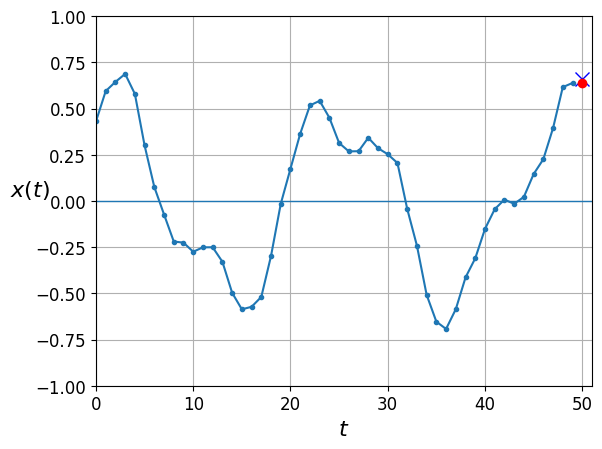

In [ ]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

Linear predictions:

In [ ]:
np.random.seed(42)
torch.manual_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

In [ ]:
model.evaluate(X_valid, y_valid)

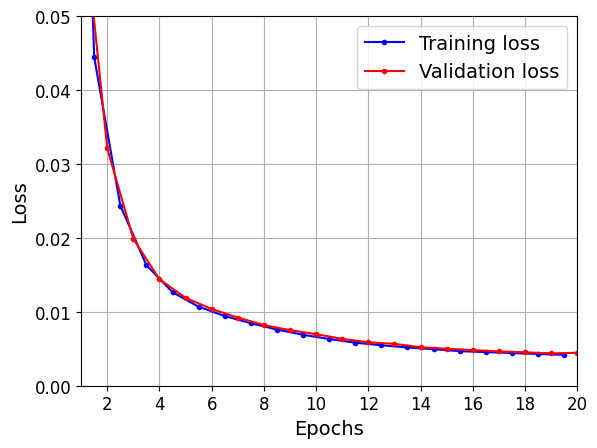

In [ ]:
def plot_learning_curves(loss, val_loss):
    plt.plot(torch.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(torch.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)


plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


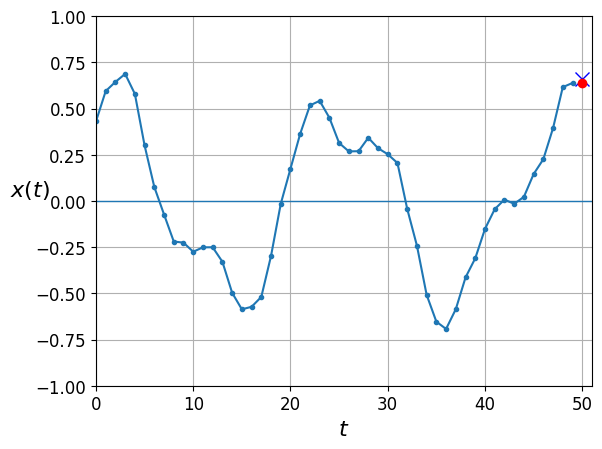

In [ ]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

### Using a Simple RNN

In [ ]:
np.random.seed(42)
torch.manual_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

optimizer = keras.optimizers.Adam(learning_rate=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:203: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - loss: 0.2258 - val_loss: 0.1405
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - loss: 0.1426 - val_loss: 0.1530
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - loss: 0.1472 - val_loss: 0.1449
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - loss: 0.1437 - val_loss: 0.1479
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - loss: 0.1448 - val_loss: 0.1492
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - loss: 0.1432 - val_loss: 0.0881
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - loss: 0.0671 - val_loss: 0.0409
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - loss: 0.0363 - val_loss: 0.0294
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step - loss: 0.0276 - val_loss: 0.0237
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - loss: 0.0224 - val_loss: 0.0201
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - loss: 0.0188 - val_loss: 0.0177
Epoch 12/20
219/219 ━━━━━━━━━━

In [ ]:
model.evaluate(X_valid, y_valid)

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0119


0.011687241494655609

In [ ]:
model.evaluate(X_test, y_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0106


0.011204185895621777

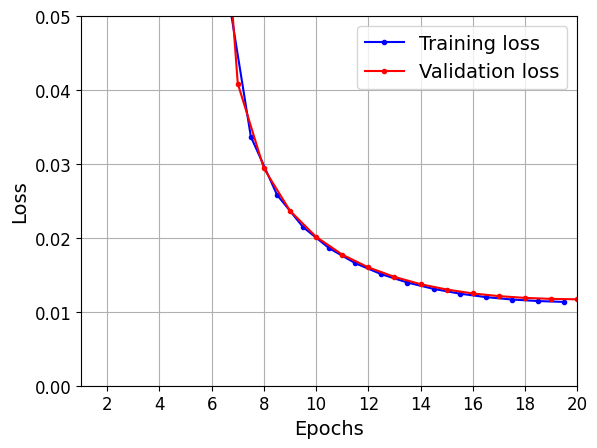

In [ ]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step


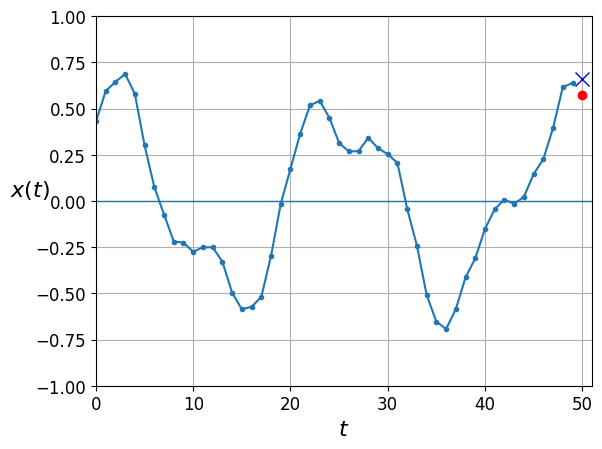

In [ ]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

#### Use directly Pythorch


In [ ]:
# Define the RNN-based model
class SimpleRNNModel(nn.Module):
    def __init__(self):
        super(SimpleRNNModel, self).__init__()
        self.rnn = nn.RNN(input_size=1, hidden_size=1, batch_first=True)  # SimpleRNN equivalent

    def forward(self, x):
        out, _ = self.rnn(x)
        return out[:, -1, :]    # Return only the last timestep


In [ ]:
# Initialize the model, optimizer, and loss function

device = torch.device('cuda' if use_cuda else 'cpu')

model = SimpleRNNModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.005)
criterion = nn.MSELoss().to(device)

In [ ]:

# Train the model with batches
train_model(model, X_train, y_train, X_valid, y_valid, optimizer, criterion, device, epochs=20)

  5%|▌         | 1/20 [00:01<00:20,  1.10s/it]

Epoch [1/20], Training Loss: 0.1440, Validation Loss: 0.0307


 10%|█         | 2/20 [00:01<00:12,  1.38it/s]

Epoch [2/20], Training Loss: 0.0266, Validation Loss: 0.0236


 15%|█▌        | 3/20 [00:02<00:10,  1.64it/s]

Epoch [3/20], Training Loss: 0.0210, Validation Loss: 0.0193


 20%|██        | 4/20 [00:02<00:08,  1.81it/s]

Epoch [4/20], Training Loss: 0.0175, Validation Loss: 0.0164


 25%|██▌       | 5/20 [00:02<00:07,  1.92it/s]

Epoch [5/20], Training Loss: 0.0151, Validation Loss: 0.0144


 30%|███       | 6/20 [00:03<00:07,  1.99it/s]

Epoch [6/20], Training Loss: 0.0136, Validation Loss: 0.0132


 35%|███▌      | 7/20 [00:03<00:06,  2.05it/s]

Epoch [7/20], Training Loss: 0.0126, Validation Loss: 0.0124


 40%|████      | 8/20 [00:04<00:05,  2.07it/s]

Epoch [8/20], Training Loss: 0.0119, Validation Loss: 0.0120


 45%|████▌     | 9/20 [00:04<00:05,  2.10it/s]

Epoch [9/20], Training Loss: 0.0115, Validation Loss: 0.0117


 50%|█████     | 10/20 [00:05<00:04,  2.09it/s]

Epoch [10/20], Training Loss: 0.0114, Validation Loss: 0.0117


 55%|█████▌    | 11/20 [00:05<00:04,  2.11it/s]

Epoch [11/20], Training Loss: 0.0113, Validation Loss: 0.0117


 60%|██████    | 12/20 [00:06<00:03,  2.10it/s]

Epoch [12/20], Training Loss: 0.0113, Validation Loss: 0.0116


 65%|██████▌   | 13/20 [00:06<00:03,  2.12it/s]

Epoch [13/20], Training Loss: 0.0113, Validation Loss: 0.0116


 70%|███████   | 14/20 [00:07<00:02,  2.13it/s]

Epoch [14/20], Training Loss: 0.0113, Validation Loss: 0.0117


 75%|███████▌  | 15/20 [00:07<00:02,  2.13it/s]

Epoch [15/20], Training Loss: 0.0113, Validation Loss: 0.0117


 80%|████████  | 16/20 [00:08<00:01,  2.14it/s]

Epoch [16/20], Training Loss: 0.0112, Validation Loss: 0.0117


 85%|████████▌ | 17/20 [00:08<00:01,  1.98it/s]

Epoch [17/20], Training Loss: 0.0113, Validation Loss: 0.0117


 90%|█████████ | 18/20 [00:09<00:01,  1.89it/s]

Epoch [18/20], Training Loss: 0.0113, Validation Loss: 0.0116


 95%|█████████▌| 19/20 [00:09<00:00,  1.80it/s]

Epoch [19/20], Training Loss: 0.0113, Validation Loss: 0.0116


100%|██████████| 20/20 [00:10<00:00,  1.90it/s]

Epoch [20/20], Training Loss: 0.0113, Validation Loss: 0.0117


In [ ]:
evaluate_model(model, X_test, y_test, device)

Validation Loss: 0.0112


0.011223358206450939

## Deep RNNs

In [ ]:
np.random.seed(42)
torch.manual_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss="mse", optimizer="adam")
model.summary()

In [ ]:
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

In [ ]:
model.evaluate(X_valid, y_valid)

In [ ]:
model.evaluate(X_test, y_test)

In [ ]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [ ]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

Make the second `SimpleRNN` layer return only the last output:

In [ ]:
np.random.seed(42)
torch.manual_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
model.summary()

In [ ]:
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

In [ ]:
model.evaluate(X_valid, y_valid)

In [ ]:
model.evaluate(X_test, y_test)

In [ ]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [ ]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

#### Use directly Pythorch

In [ ]:
# Define the RNN-based model
class DeepRNNModel(nn.Module):
    def __init__(self):
        super(DeepRNNModel, self).__init__()
        self.rnn1 = nn.RNN(input_size=1, hidden_size=20, batch_first=True)  # SimpleRNN equivalent
        self.rnn2 = nn.RNN(input_size=20, hidden_size=20, batch_first=True)  # SimpleRNN equivalent
        self.linear = nn.Linear(20, 1)

    def forward(self, x):
        out, _ = self.rnn1(x)
        out, _ = self.rnn2(out)
        out = out[:, -1, :]             # Passing only the last timestep to the classifier
        return self.linear(out)


In [ ]:
# Initialize the model, optimizer, and loss function

device = torch.device('cuda' if use_cuda else 'cpu')

model = DeepRNNModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.005)
criterion = nn.MSELoss().to(device)

In [ ]:

# Train the model with batches
train_model(model, X_train, y_train, X_valid, y_valid, optimizer, criterion, device, epochs=20)

In [ ]:
evaluate_model(model, X_test, y_test)

## Forecasting Several Steps Ahead

In [ ]:
np.random.seed(43) # not 42, as it would give the first series in the train set

series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

In [ ]:
Y_pred.shape

In [ ]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
save_fig("forecast_ahead_plot")
plt.show()

Now let's use this model to predict the next 10 values. We first need to regenerate the sequences with 9 more time steps.

In [ ]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

Now let's predict the next 10 values one by one:

In [ ]:
X = X_valid
for step_ahead in range(10):
    y_pred_one = model.predict(X)[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:, 0]

In [ ]:
Y_pred.shape

Let's compare this performance with some baselines: naive predictions and a simple linear model:

In [ ]:
torch.mean (keras.losses.mean_squared_error(Y_valid, Y_pred))


In [ ]:
Y_naive_pred = Y_valid[:, -1:]
torch.mean(keras.losses.mean_squared_error(Y_valid, Y_naive_pred))

In [ ]:
np.random.seed(42)
torch.manual_seed(42)

model_seq = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(10)
])

model_seq.compile(loss="mse", optimizer="adam")
history = model_seq.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

In [ ]:
model_seq.evaluate(X_test, Y_test)

Now let's create an RNN that predicts all 10 next values at once:

In [ ]:
np.random.seed(42)
torch.manual_seed(42)

model_rnn = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

model_rnn.compile(loss="mse", optimizer="adam")
history = model_rnn.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

In [ ]:
model_rnn.evaluate(X_test, Y_test)

In [ ]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model_rnn.predict(X_new)[..., np.newaxis]

In [ ]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

Now let's create an RNN that predicts the next 10 steps at each time step. That is, instead of just forecasting time steps 50 to 59 based on time steps 0 to 49, it will forecast time steps 1 to 10 at time step 0, then time steps 2 to 11 at time step 1, and so on, and finally it will forecast time steps 50 to 59 at the last time step. Notice that the model is causal: when it makes predictions at any time step, it can only see past time steps.

In [ ]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [ ]:
X_train.shape, Y_train.shape

In [ ]:
np.random.seed(42)
torch.manual_seed(42)

model_td = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

def last_time_step_mse(Y_true, Y_pred):
    return keras.losses.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model_td.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=[last_time_step_mse])
history = model_td.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

In [ ]:
model_td.evaluate(X_test, Y_test)

In [ ]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model_td.predict(X_new)[:, -1][..., np.newaxis]

In [ ]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

# Deep RNN with Batch Norm

In [ ]:
np.random.seed(42)
torch.manual_seed(42)

model_bn = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.BatchNormalization(),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model_bn.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model_bn.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

In [ ]:
model_bn.evaluate(X_test, Y_test)

# LSTMs

Now let's use this model to predict the next 10 values. We first need to regenerate the sequences with 9 more time steps.

In [ ]:
#Already defined; included for an easier reload
#Same as before...
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = torch.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [ ]:
def last_time_step_mse(Y_true, Y_pred):
    return (keras.losses.mean_squared_error(Y_true[:, -1], Y_pred[:, -1]))


In [ ]:
np.random.seed(42)
torch.manual_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
model.summary()

In [ ]:
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

In [ ]:
model.evaluate(X_valid, Y_valid)

In [ ]:
model.evaluate(X_test, Y_test)

In [ ]:
np.random.seed(42)
torch.manual_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
model.summary()

In [ ]:
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

In [ ]:
model.evaluate(X_valid, Y_valid)

In [ ]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [ ]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

In [ ]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

# GRUs

In [ ]:
np.random.seed(42)
torch.manual_seed(42)

model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
model.summary()

In [ ]:

history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

In [ ]:
model.evaluate(X_valid, Y_valid)

In [ ]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [ ]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

In [ ]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()